### Machine Learning: TF Audio Classification Model Creation and Training Evaluation Document
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
from netplot import ModelPlot
from tensorflow.keras.utils import plot_model
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.7.0
Num GPUs Available:  1


2022-01-22 16:49:16.844944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 16:49:16.963578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 16:49:16.963835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### MFCC CNN
In this section we will construct our MFCC CNN

In [2]:
# os path to desktop
#desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')

dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load the training data
dataset_train_folder = os.path.join(dataset_root_dir, 'train')
dataset_train_csv = os.path.join(dataset_train_folder, 'catalog.csv')

# load in our data_frame
metadata = pd.read_csv(dataset_train_csv)

# Pre-processed MFCC coefficients
X = np.load( os.path.join(data_npy_folder, "X-mfcc.npy" ) )
y = np.load( os.path.join(data_npy_folder, "y-mfcc.npy" ) )


In [3]:
# create train and test sets
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))


Test split: 1894 		 Train split: 7579
X test shape: (1894, 40, 2584) 	 X train shape: (7579, 40, 2584)
y test shape: (1894,) 		 y train shape: (7579,)


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


In [5]:
y_test[2]

'Gong'

In [6]:
y_test_encoded[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [7]:
# How data should be structured
num_rows = 40
num_columns = 2584 
num_channels = 1

# Reshape to fit the network input (channel last)

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [8]:
num_labels

41

In [9]:
# set the random seed
tf.random.set_seed(42)


# IMAGE_HEIGHT = X_train.shape[0]#spectrogram_shape[0]
# IMAGE_WIDTH = X_train.shape[1]#40#spectrogram_shape[1]
# N_CHANNELS = X_train.shape[2]#2584#2
#N_CLASSES = num_labels#len(y_train_encoded)

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

# Create a secquential object
model = Sequential()


# Conv 1
model.add(Conv2D(filters=32, 
                    kernel_size=(3, 3), 
                    kernel_regularizer=l2(l2_rate), 
                    input_shape=(num_rows, num_columns, num_channels)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(SpatialDropout2D(spatial_dropout_rate_1))
model.add(Conv2D(filters=32, 
                    kernel_size=(3, 3), 
                    kernel_regularizer=l2(l2_rate)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())


# Max Pooling #1
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(SpatialDropout2D(spatial_dropout_rate_1))
model.add(Conv2D(filters=64, 
                    kernel_size=(3, 3), 
                    kernel_regularizer=l2(l2_rate)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(SpatialDropout2D(spatial_dropout_rate_2))
model.add(Conv2D(filters=64, 
                    kernel_size=(3,3), 
                    kernel_regularizer=l2(l2_rate)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())


# Reduces each h×w feature map to a single number by taking the average of all h,w values.
model.add(GlobalAveragePooling2D())


# Softmax output
model.add(Dense(num_labels, activation='softmax'))

# # Create CNN model
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(num_rows, num_columns, num_channels)))
# model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))


2022-01-22 16:49:24.959921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-22 16:49:24.961570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 16:49:24.962125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 16:49:24.962596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

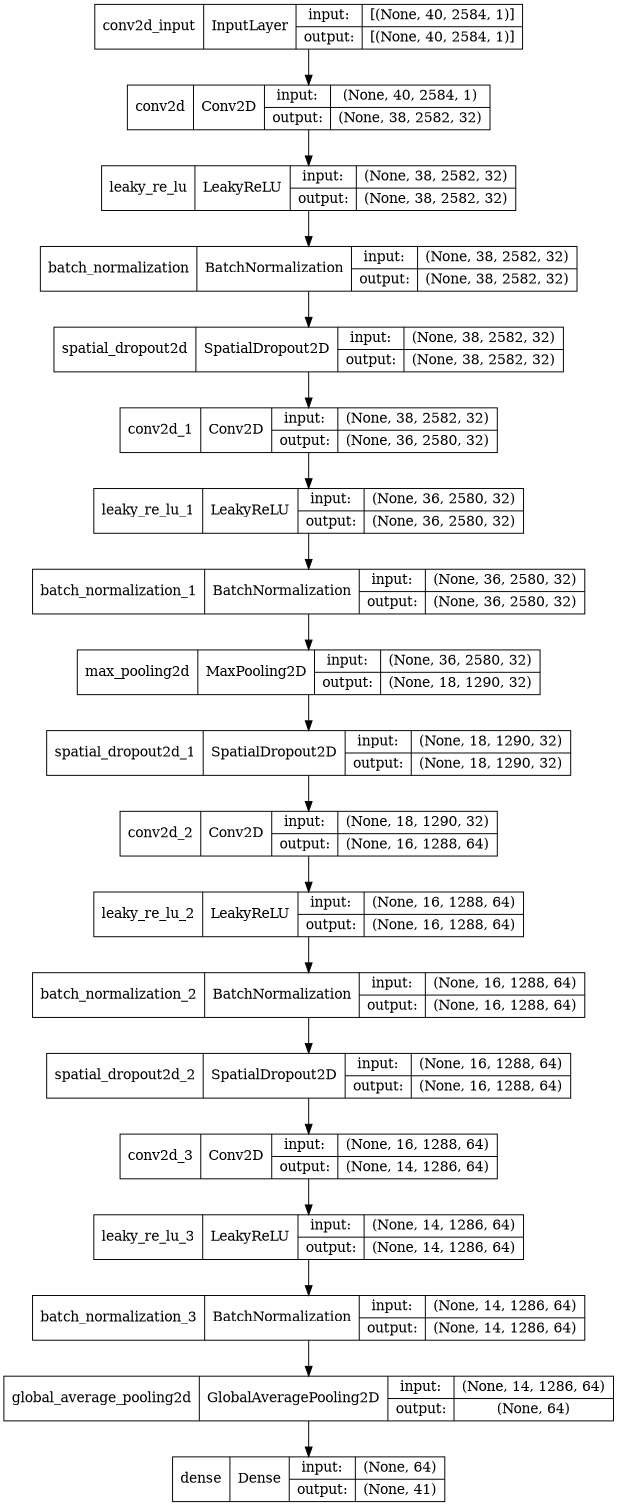

In [10]:
# 2. compile the model
model.compile(
    loss = tf.keras.losses.mae, # mean absolute error predicted vs observed
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), # stochastic gradient descent (lr=1e-3)
    metrics=['mae'] # mean absolute error
)

plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

In [11]:
# modelplot = ModelPlot(model=model, grid=True, connection=False, linewidth=0.1)
# modelplot.show()
# get the directory of the model output
model_dir = os.path.join( dataset_root_dir, 'models')
model_path = os.path.join(model_dir, 'MLAC_K2018_MFCC.h5')

In [12]:

# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# # early stopping callback
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='mae',
#     patience=3
# )

from datetime import datetime
start = datetime.now()

# 3. train the model

num_epochs = 250
num_batch_size = 8#16#64#128

history = model.fit(
    X_train, 
    y_train_encoded, 
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    validation_split=1/12.,
    callbacks=[checkpointer], 
    verbose=1
)

# history = model.fit(
#     X_train,
#     y_train_encoded,
#     epochs=250,
#     verbose=1,
#     callbacks=[early_stopping_callback, checkpointer],
#     validation_data=(X_test, y_test_encoded)
# )

end = datetime.now() - start
print("Training time: {}".format(end))

2022-01-22 16:49:25.957299: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2872167680 exceeds 10% of free system memory.
2022-01-22 16:49:27.408066: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2872167680 exceeds 10% of free system memory.


Epoch 1/250


2022-01-22 16:49:29.931302: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


869/869 [==============================] - ETA: 0s - loss: 0.0689 - mae: 0.0470
Epoch 00001: val_loss improved from inf to 0.05095, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MLAC_K2018_MFCC.h5
869/869 [==============================] - 57s 63ms/step - loss: 0.0689 - mae: 0.0470 - val_loss: 0.0509 - val_mae: 0.0465
Epoch 2/250
868/869 [============================>.] - ETA: 0s - loss: 0.0486 - mae: 0.0459
Epoch 00002: val_loss improved from 0.05095 to 0.04732, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MLAC_K2018_MFCC.h5
869/869 [==============================] - 56s 64ms/step - loss: 0.0486 - mae: 0.0459 - val_loss: 0.0473 - val_mae: 0.0456
Epoch 3/250
868/869 [============================>.] - ETA: 0s - loss: 0.0469 - mae: 0.0455
Epoch 00003: val_loss improved from 0.04732 to 0.04590, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MLAC_K2018_MFCC.h5
869/869 [==============================] - 55s 

Text(0.5, 0, 'epochs')

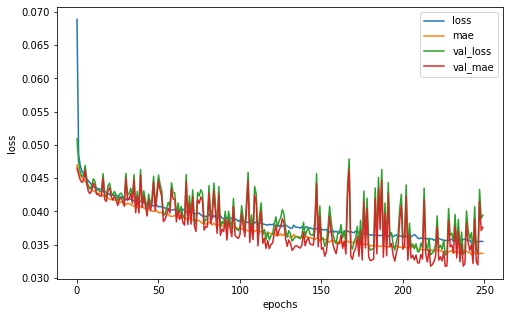

In [18]:
# plot history also known as loss curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

In [22]:
model_path = os.path.join(model_dir, '250EPOCH_MLAC_K2018_MFCC.h5')

# Load best saved model
model = load_model(model_path)


test_score = model.evaluate(X_test, y_test, verbose=0)
test_score
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     #train_score = model.evaluate(X_train, y_train, verbose=0)
#     test_score = model.evaluate(X_test, y_test, verbose=0)
#     return test_score#train_score, test_score


# def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
#     dash = '-' * 38

#     # Compute scores
#     train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)

#     # Pint Train vs Test report
#     print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
#     print(dash)
#     print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
#     print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))


#     # Calculate and report normalized error difference?
#     if (calc_normal):
#         max_err = max(train_score[0], test_score[0])
#         error_diff = max_err - min(train_score[0], test_score[0])
#         normal_diff = error_diff * 100 / max_err
#         print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

#length = len(a_list)

#model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)


In [20]:

model.metrics_names

['loss', 'mae']